In [13]:
# !pip install -q transformers[sentencepiece]
# !pip install -q transformers[torch]
# !pip install -q datasets

In [14]:
import pandas as pd 
from sklearn.model_selection import train_test_split 

#loadin the dataset
url = "https://gitlab.com/valdanchev/data-storage-for-teaching-ml/-/raw/main/yelp_reviews_data_500.csv"
df = pd.read_csv(url)


In [15]:
df.head()

,text,label
0,"Unfortunately, the frustration of being Dr. Go...",0
1,Been going to Dr. Goldberg for over 10 years. ...,1
2,I don't know what Dr. Goldberg was like before...,0
3,I'm writing this review to give you a heads up...,0
4,All the food is great here. But the best thing...,1


<Axes: >

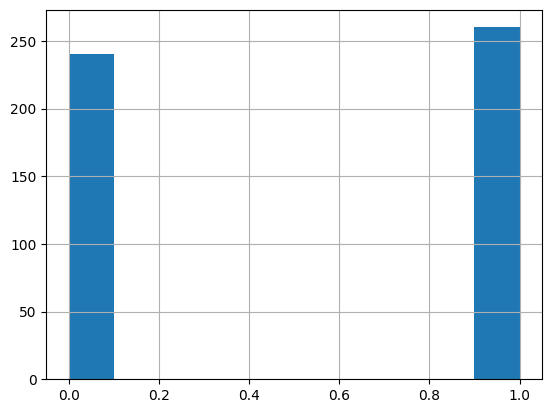

In [16]:
# histogram of labels
df.label.hist()

In [18]:
# remove stopwords
from nltk.corpus import stopwords 
import nltk 

nltk.download('stopwords')
stop = stopwords.words('english')
df['text_preprocessed'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# stemming
from nltk.stem import PorterStemmer 
stemmer = PorterStemmer()
df['text_preprocessed'] = df['text_preprocessed'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maiab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


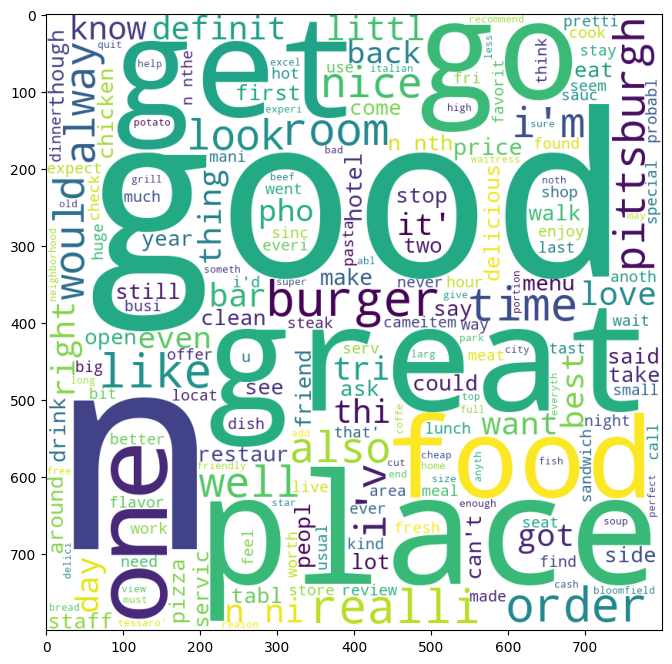

In [19]:
# plot word cloud
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 

# plot positive words
positive_df = df[df['label'] == 1].copy()
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop,
                min_font_size = 10).generate(' '.join(positive_df['text_preprocessed']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)

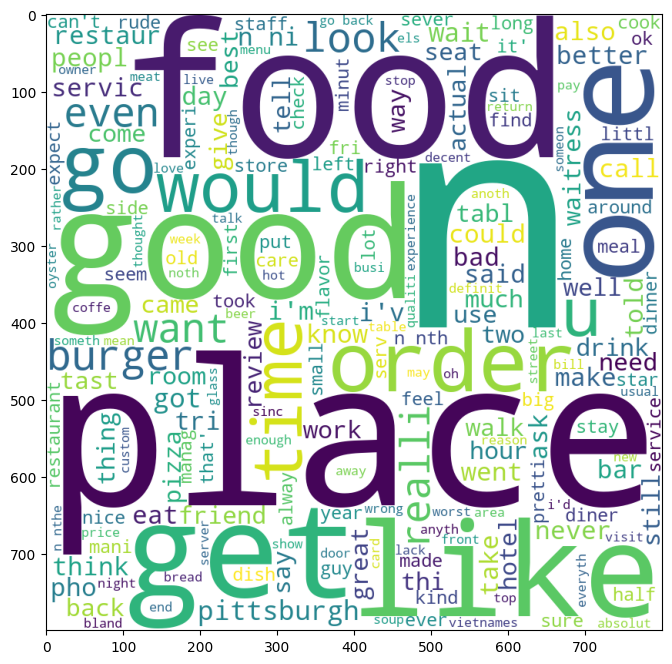

In [20]:
negative_df = df[df['label'] == 0].copy()
# plot negative words
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop,
                min_font_size = 10).generate(' '.join(negative_df['text_preprocessed']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)

EDA Analysis:
* data is small, not very generalizable.
* models based on word count such as tf-idf or bag of words are gonna suffer due to overlap in words of the target sentiment in both labels.
* deep learning methods are preffered to deal with this data as they provide contextual insights.

In [21]:
from transformers import AutoTokenizer 
import datasets 

model_name = "google-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)


df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# convert df to dataset
dataset_train = datasets.Dataset.from_pandas(df_train[['text', 'label']], split='train')
dataset_test = datasets.Dataset.from_pandas(df_test[['text', 'label']], split='test')

# tokenize the dataset
dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_test = dataset_test.map(tokenize_function, batched=True)


Map: 100%|██████████| 100/100 [00:00<00:00, 1864.13 examples/s]


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # type: ignore

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [2]:
from transformers import TFTrainer, TFAutoModelForSequenceClassification

# Define the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=df['label'].nunique())

# Create the trainer object
trainer = TFTrainer(model=model, train_dataset=dataset_train, eval_dataset=dataset_test, compute_metrics=compute_metrics)



ImportError: cannot import name 'TFTrainer' from 'transformers' (c:\Users\maiab\miniconda3\envs\misc\lib\site-packages\transformers\__init__.py)

In [ ]:
# save the model

model.config.label2id = {'negative': 0, 'positive': 1}
model.config.id2label = {0: 'negative', 1: 'positive'}

model.save_pretrained('sentiment_analysis_model')


NameError: name 'model' is not defined

In [45]:
# load the model
model = AutoModelForSequenceClassification.from_pretrained('sentiment_analysis_model')

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFAutoModelForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [6]:
# predict
%%pip install transformers
transformers import pipeline 

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
print(classifier('I love you'))


NameError: name 'model' is not defined

In [43]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
print(classifier('I hate you'))


RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
cannot import name 'is_torch_mlu_available' from 'transformers.utils' (c:\Users\maiab\miniconda3\envs\misc\lib\site-packages\transformers\utils\__init__.py)